<div style="border:solid green 5px; padding: 20px"> 

<font size="5"> Проект: Интернет-магазин «Викишоп»


<font size="5"><b>Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


<font size="5"><strong>Исходные данные.</strong></p>


Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<font size="5"><b>Цель проекта

Постройте модель со значением метрики качества F1 не меньше 0.75.

<font size="5"><b>План работы </b>

1. Загрузка и подготовка данных.
2. Обучение 2х моделей (DecisionTreeClassifier, LogisticRegression).
3. Вывод.

### Импорты

#### Импорты библиотек 

In [1]:
!pip install tqdm -q

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from pymystem3 import Mystem

import warnings
warnings.simplefilter("ignore")

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Константы и цветовые настройки

In [4]:
sns.set_theme(style="whitegrid")
colors = sns.color_palette('deep')

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#### Импорт данных

In [6]:
local_data_path = '/Users/malkovkonstantin/Desktop/DS/Jupiter'

files = {
    'comm': 'toxic_comments.csv'}

dfs = {} 

for name, filename in files.items():
    file_path = os.path.join(local_data_path, filename)
    if os.path.exists(file_path):
        dfs[name] = pd.read_csv(file_path)
    else:
        url = f'https://code.s3.yandex.net/datasets/{filename}'
        dfs[name] = pd.read_csv(url)

for name, df in dfs.items():
    df.name = name
        
for name, df in dfs.items():
    globals()[name] = df

In [7]:
for name in dfs:
    print(name)

comm


## Подготовка

In [8]:
comm.sample(10)

,Unnamed: 0,text,toxic
118988,119088,Manuel Rivera-Ortiz \n\nDoes anyone else think...,0
60448,60515,"""\nI should probably let you know in advance t...",0
115373,115472,"You owe me an apology\nIf you don't see that, ...",0
49025,49080,"""\nHello, I noticed that you created on after ...",0
30185,30225,"Greetings, nice work for a start! The article ...",0
2889,2889,This is my original account that dates back to...,0
142094,142247,"""\n\n Assad abuses \n\nReviving the previous d...",0
141554,141707,Last successful Invasion? British democracy?\n...,0
81908,81984,you guys are idiots. I clearly don't care abou...,1
104802,104899,"""\n I would have guessed that it was Canadiand...",0


In [9]:
comm.shape

(159292, 3)

In [10]:
comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [11]:
comm.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
toxic,159292.0,0.101612,0.302139,0.0,0.00,0.0,0.00,1.0


Unnamed: 0 - скорее всего предидущие индексы, сохранившиеся после удаления строк. Удалим столбец

In [12]:
comm = comm.drop('Unnamed: 0', axis = 1)
comm.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [13]:
comm.duplicated().sum()

0

In [14]:
display(comm.isna().sum().to_frame())


,0
text,0
toxic,0


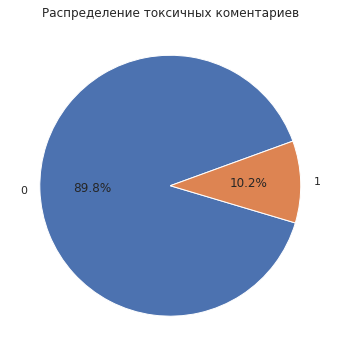

In [15]:
percentages = comm['toxic'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,6))  
percentages.plot(kind='pie', autopct='%1.1f%%', startangle=20)
plt.ylabel('')
plt.title('Распределение токсичных коментариев')
plt.show()

### Вывод

Мы загрузили датасет, который содержит 159292 строки и 3 столбца. 
- В процессе работы был удален столбец 'Unnamed: 0'. 
- Пропущенные значения и дубликаты не были обнаружены. 
- Целевой признак 'toxic' представлен с несбалансированными классами, где класс 0 значительно превышает класс 1 в численности. 
- Дисбаланс классов учтем при разделении данных на обучающую и тестовую выборки.

## Лемматизация текста

Приведем текст к нижнему регистру, избавимся от сокращений, знаков препинания и пробелов.

In [16]:
def remove_odd(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]|what's|\'s|\'ve|can't|n't|i'm|\'re|\'d|\'ll", lambda m: 
        ' what is ' if m.group() == "what's" else 
        ' is ' if m.group() == "'s" else 
        ' have ' if m.group() == "'ve" else 
        ' cannot ' if m.group() == "can't" else 
        ' not ' if m.group() == "n't" else 
        'i am ' if m.group() == "i'm" else 
        ' are ' if m.group() == "'re" else 
        ' would ' if m.group() == "'d" else 
        ' will ' if m.group() == "'ll" else 
        ' ', text)
    text = re.sub(r'\s+', ' ', text)  
    text = text.strip()  
    
    return text

In [17]:
comm['text_clear'] = comm['text'].apply(lambda x: remove_odd(x.lower()))
display(comm.head())

,text,toxic,text_clear
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i am s...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cannot make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


определение тега POS

In [18]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

выполним лемматизацию

In [19]:
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(x, get_wordnet_pos(x)) for x in nltk.word_tokenize(text)])
    return lemmatized_text

In [20]:
%%time
tqdm.pandas()
comm['lemmatized'] = comm['text_clear'].progress_apply(lemmatize_text)

100%|██████████| 159292/159292 [18:29<00:00, 143.57it/s]

CPU times: user 16min 44s, sys: 1min 30s, total: 18min 14s
Wall time: 18min 29s


In [21]:
comm.head()

,text,toxic,text_clear,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i am s...,d aww he match this background colour i be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...,hey man i be really not try to edit war it s j...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cannot make any real suggestions on imp...,more i can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


Удалим не нужные столбцы

In [22]:
comm = comm.drop(['text', 'text_clear'], axis=1)
comm.head(5)

,toxic,lemmatized
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i be see...
2,0,hey man i be really not try to edit war it s j...
3,0,more i can not make any real suggestion on imp...
4,0,you sir be my hero any chance you remember wha...


In [23]:
comm.duplicated().sum()


1313

In [24]:
comm = comm.drop_duplicates()


In [25]:
comm.duplicated().sum()


0

In [26]:
comm.shape

(157979, 2)

### Вывод

<p>Мы провели подготовку данных для дальнейшего анализа с помощью следующих шагов:</p>
<ul>
    <li><strong>Приведение к нижнему регистру:</strong> Все текстовые данные были приведены к нижнему регистру, что помогает унифицировать данные и избежать проблем с учетом регистра в дальнейшем анализе.</li>
    <li><strong>Лемматизация:</strong> Процесс лемматизации позволил нам привести слова в тексте к их базовым формам (леммам). Это помогает уменьшить размерность данных, сохраняя при этом смысловую составляющую.</li>
    <li><strong>Токенизация:</strong> Текст был разбит на токены, что необходимо для дальнейшей работы с текстовыми данными</li>
    <li><strong>Удаление лишних символов и признаков:</strong> Из текста были удалены лишние символы и признаки, такие как знаки препинания, специальные символы и другие нежелательные элементы, которые не несут смысловой нагрузки для анализа.</li>
    <li>
        <p><strong>Удаление дубликатов после лемматизации:</strong> &nbsp;1313 дубликатов удаленно.</p>
        <p>&nbsp;</p>
           </li> </ul>
<p>Эти шаги помогли нам подготовить данные к дальнейшему анализу и построению моделей, обеспечивая чистоту и однородность данных для точного и эффективного анализа текстовой информации.</p>



## Обучение

### Разбивка на тренировочную и тестовую выборки, подготовка данных


In [27]:
# X = comm.drop('toxic', axis = 1)
X = comm['lemmatized']
y = comm['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(118484,)
(39495,)
(118484,)
(39495,)


In [29]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('clf', LogisticRegression(solver='liblinear', random_state = RANDOM_STATE)),
    ]
)

In [30]:
param_grid = [
    {
        'clf': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'clf__max_depth': range(2, 5)
    },
    {
        'clf': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        )],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.1, 1.0, 10.0],
        'clf__class_weight': ['balanced']
    }
]

In [31]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

In [32]:
%%time
random_search.fit(X_train, y_train)
print("ok")

ok
CPU times: user 3min 48s, sys: 1min, total: 4min 49s
Wall time: 4min 49s


In [33]:
print('Best parameters:', random_search.best_params_)
print('Best F1 score:', random_search.best_score_)

Best parameters: {'clf__penalty': 'l2', 'clf__class_weight': 'balanced', 'clf__C': 10.0, 'clf': LogisticRegression(C=10.0, class_weight='balanced', random_state=42,
                   solver='liblinear')}
Best F1 score: 0.7564906930872832


In [34]:
preds = random_search.predict(X_test)
print('F1 score:', f1_score(y_test, preds))

F1 score: 0.7541918558229725


In [35]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))

F1 Score: 0.16835640065626184


Вывод: Использование более сложной и продвинутой модели значительно улучшило качество предсказаний по сравнению с простой dummy-моделью.

## Выводы

 <ul>
    <li>Проанализировав предоставленный датасет, мы обнаружили, что он содержит 159292 строк и 3 столбца. Первым шагом было удаление неинформативного столбца 'Unnamed: 0'.</li>
    <li>В ходе предобработки данных не было обнаружено пропущенных значений или дубликатов.&nbsp;</li>
    <li>Применена лемматизация текста с удалением ненужных символов. В процессе лемматизации удалено 1313 дубликата.</li>
    <li>Далее данные были разбиты на тренировочную и тестовую выборки с соотношением 3:1.</li>
    <li>Применена трансформация текстов в векторы с использованием TF-IDF с помощью пайплайна.</li>
    <li>Обучены две модели: LogisticRegression и DecisionTreeClassifier. </li>
    <li>На тренировочной выборке лучший результат показала модель LogisticRegression с параметрами Best parameters: ('clf__penalty': 'l2', 'clf__class_weight': 'balanced', 'clf__C': 10.0), достигнув значения F1 равного 0.756, что соответствует требованиям задачи.</li>
    <li>На тестовой выборке модель также продемонстрировала хорошие результаты с метрикой F1 равной 0.754, полностью удовлетворяя условиям задачи.</li>
</ul>